In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn

In [2]:
default = pd.read_csv('../Data/Default.csv', index_col=0)

In [3]:
default.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


In [4]:
# pandas also has a good functionality for working with excel
xlsx = pd.ExcelFile('../Data/Default.xlsx')
df = pd.read_excel(xlsx, 'Sheet1')

In [5]:
# There's some floating point mischief happening between the two imports, so to check that they are in fact the same
print("Both dataframes have same columns with same dtypes: {}".format(all(default.dtypes==df.dtypes)))
for col, typ in df.dtypes.iteritems():
    if typ == 'float64':
        print("{c}: {b}".format(c=col, b= all(np.isclose(default[col].values, df[col].values))))
    else:
        print("{c}: {b}".format(c=col, b= all(default[col] == df[col])))

Both dataframes have same columns with same dtypes: True
default: True
student: True
balance: True
income: True


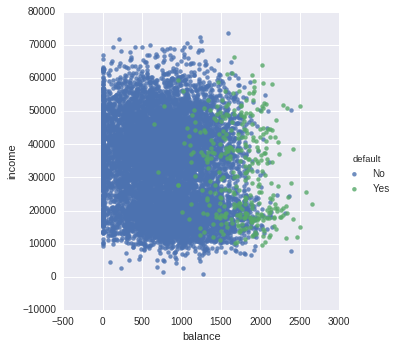

In [6]:
# note the graphic in the book plots only a fraction of the non-defaults
sns.lmplot(x='balance',y='income', hue='default', data=df, fit_reg=False)

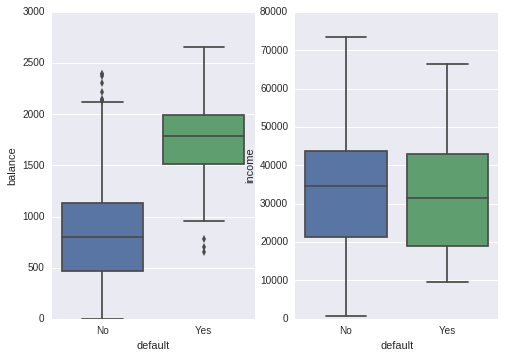

In [7]:
# if you figure out the spacing between the plots please let me know
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)
sns.boxplot(x='default', y='balance', data=default, ax=ax1)
sns.boxplot(x='default', y='income', data=default, ax=ax2)

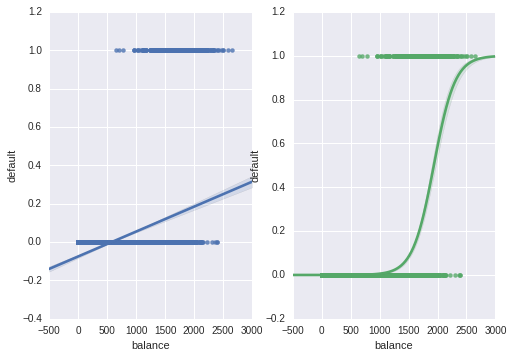

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)
sns.regplot(x=df.balance,y=df.default.map({'No': 0, 'Yes':1}), ax=ax1)
sns.regplot(x=df.balance,y=df.default.map({'No': 0, 'Yes':1}), logistic=True, ax=ax2)

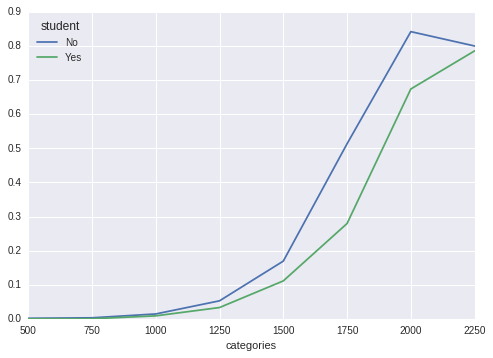

In [10]:
# Per Figure 4.3- it's unclear to me exactly what the left figure is. It may be that they binned the
# the observations by balance and then actually calculated the default rate for each bin
# This is kind of a pain, please let me know if you know a better way
bins = [500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]
df['default_int'] = df['default'].map({'Yes': 1, 'No': 0})
df['categories'] = pd.cut(df['balance'], bins, labels=bins[:-1])
means = df.groupby(['student', 'categories'])['default_int'].mean()
means.unstack().transpose().plot()

In [11]:
df.groupby('student')['default_int'].mean()

student
No     0.029195
Yes    0.043139
Name: default_int, dtype: float64

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X = df.loc[:,['student','balance','income']]
X['student'] = X.loc[:,'student'].map({"Yes": 1, "No": 0})
y = df['default_int']

In [13]:
clf1 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X.values, y.values)
clf2 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=None).fit(X.values, y.values)
score1 = clf1.score(X,y)
score2 = clf2.score(X,y)

In [14]:
# notice the training error rate without shrinkage is the same as stated in the book
print('LDA with Shrinkage scores: {} for an error rate of {:.4f}'.format(score1, 1-score1))
print('LDA with out Shrinkage scores: {} for an error rate of {:.4f}'.format(score2, 1-score2))

LDA with Shrinkage scores: 0.9724 for an error rate of 0.0276
LDA with out Shrinkage scores: 0.9725 for an error rate of 0.0275


In [15]:
# interesting that sklearn's confusion matrix is the transpose of the one in the book
# read more http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
import sklearn.metrics
sklearn.metrics.confusion_matrix(y, clf2.predict(X), labels=None)

array([[9645,   22],
       [ 253,   80]])

In [16]:
# you might find pandas cross-tab to be a nicer output, and now in the order as the book
# results are CLOSE but not exactly the same
pd.crosstab( clf2.predict(X), y)

default_int,0,1
row_0,,
0,9645,253
1,22,80


In [17]:
# when using a different threshold, table 4.5
pd.crosstab( clf2.predict_proba(X)[:,1]>0.2, y)

default_int,0,1
row_0,,
False,9435,140
True,232,193


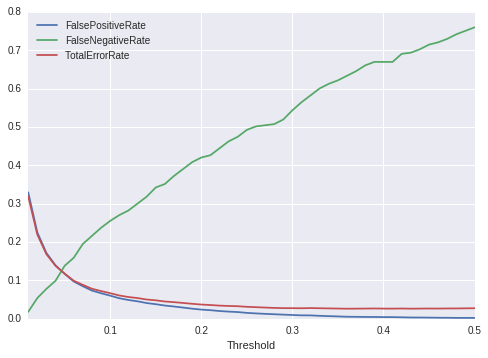

In [18]:
# recreating Figure 4.7
threshold = np.linspace(0.01, 0.5, 50)
probabilities = clf2.predict_proba(X)[:,1]
n = len(y)
errors = pd.DataFrame(threshold)
errors = errors.set_index(0)
errors.index = errors.index.rename("Threshold")
for t in threshold:
    confusion = pd.crosstab(probabilities>t,y)
    false_positives = confusion[0][True]
    false_negatives = confusion[1][False]
    errors.loc[t,'FalsePositiveRate'] = false_positives/sum(confusion[0])
    errors.loc[t,'FalseNegativeRate'] = false_negatives/sum(confusion[1])
    errors.loc[t,'TotalErrorRate'] = (false_positives + false_negatives)/n
errors.plot()

In [19]:
# in case that figure looks a little different, you can verify the numbers for the threshold of 0.5 with table 4.4
errors.loc[0.50]

FalsePositiveRate    0.002276
FalseNegativeRate    0.759760
TotalErrorRate       0.027500
Name: 0.5, dtype: float64

In [20]:
# AUC score mentioned is 0.95 as mentioned on page 147
sklearn.metrics.roc_auc_score(y,probabilities)

0.94952022468315012

In [21]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y,probabilities)

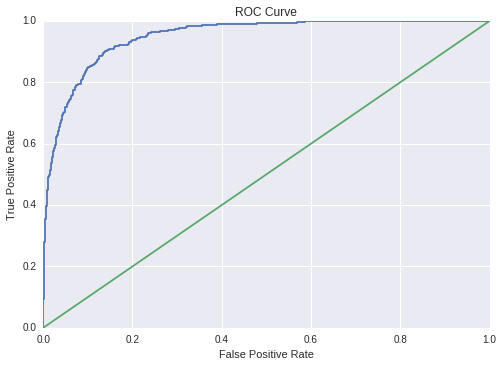

In [22]:
# figure 4.8
plt.plot(fpr,tpr)
plt.plot([0,1]) # plotting the random guess line
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')

In [23]:
# most of the lab is covered in unit4_py3.ipynb
# if you wan something specific let me know and I'll do it